In [1]:
import matplotlib.pyplot as plt
import mrcfile
import pooch
import torch
from torch_find_peaks.find_peaks import find_peaks_3d
from torch_find_peaks.refine_peaks import refine_peaks_3d

In [2]:

tomo = pooch.retrieve("https://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-25061/map/emd_25061.map.gz",known_hash=None)


In [3]:
with mrcfile.open(tomo, mode='r') as mrc:
    # print the map header
    tomo_data = torch.tensor(mrc.data).to("cuda:0")


In [4]:
with torch.inference_mode():
    # Find peaks in the 3D volume
    peak_data = find_peaks_3d(
                volume = -1. * tomo_data + torch.randn_like(tomo_data,dtype=torch.float32) * 0.001,
                threshold_abs=30,
                min_distance=5,
                return_as="dataframe",
            )

In [5]:
peak_data

,z,y,x,height
0,56.0,1450.0,516.0,128.002747
1,57.0,1442.0,520.0,128.003052
2,102.0,1050.0,249.0,128.002319
3,108.0,1050.0,249.0,128.001450
4,113.0,1185.0,134.0,62.001442
...,...,...,...,...
270,437.0,206.0,535.0,113.001297
271,448.0,149.0,634.0,88.000313
272,451.0,459.0,154.0,87.000336
273,457.0,473.0,177.0,122.000732


In [6]:
import imodmodel

imodmodel.write(peak_data, "test.mod")

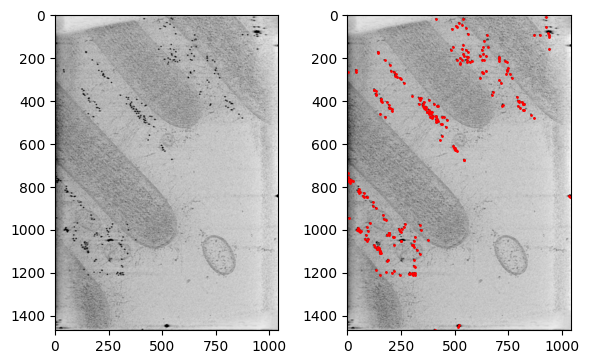

In [7]:
fig, [pl1, pl2] = plt.subplots(1, 2, figsize=(6, 4))
tomo_data_cpu = tomo_data.cpu()
pl1.imshow(torch.min(tomo_data_cpu, dim=0).values, cmap='gray',interpolation='mitchell', vmin=0, vmax=70)
pl2.imshow(torch.min(tomo_data_cpu, dim=0).values, cmap='gray',interpolation='mitchell', vmin=0, vmax=70)
pl2.plot(peak_data['x'],peak_data['y'], 'r.', markersize=2)
plt.tight_layout()
plt.show()

In [8]:
refined_peak_data = refine_peaks_3d(
    volume = -1. * tomo_data + torch.randn_like(tomo_data,dtype=torch.float32) * 0.001,
    peak_coords= peak_data,
    return_as="diagnostic",
    boxsize=10
)

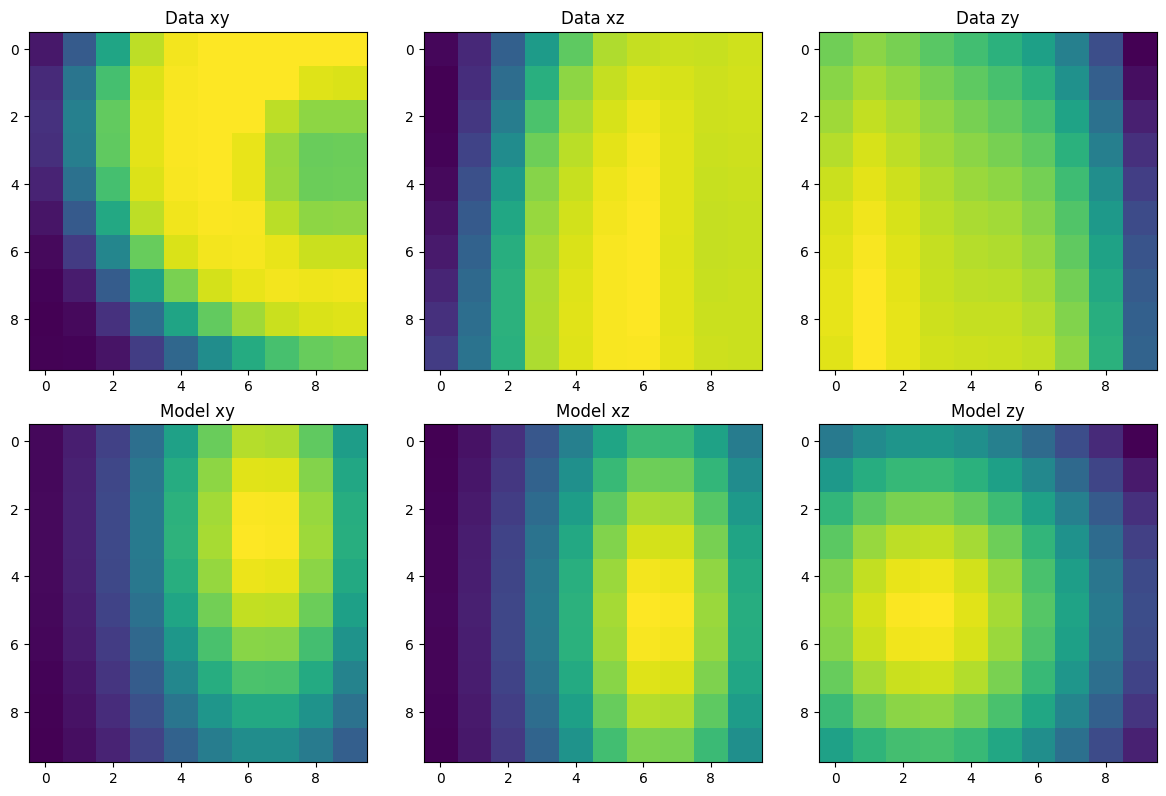

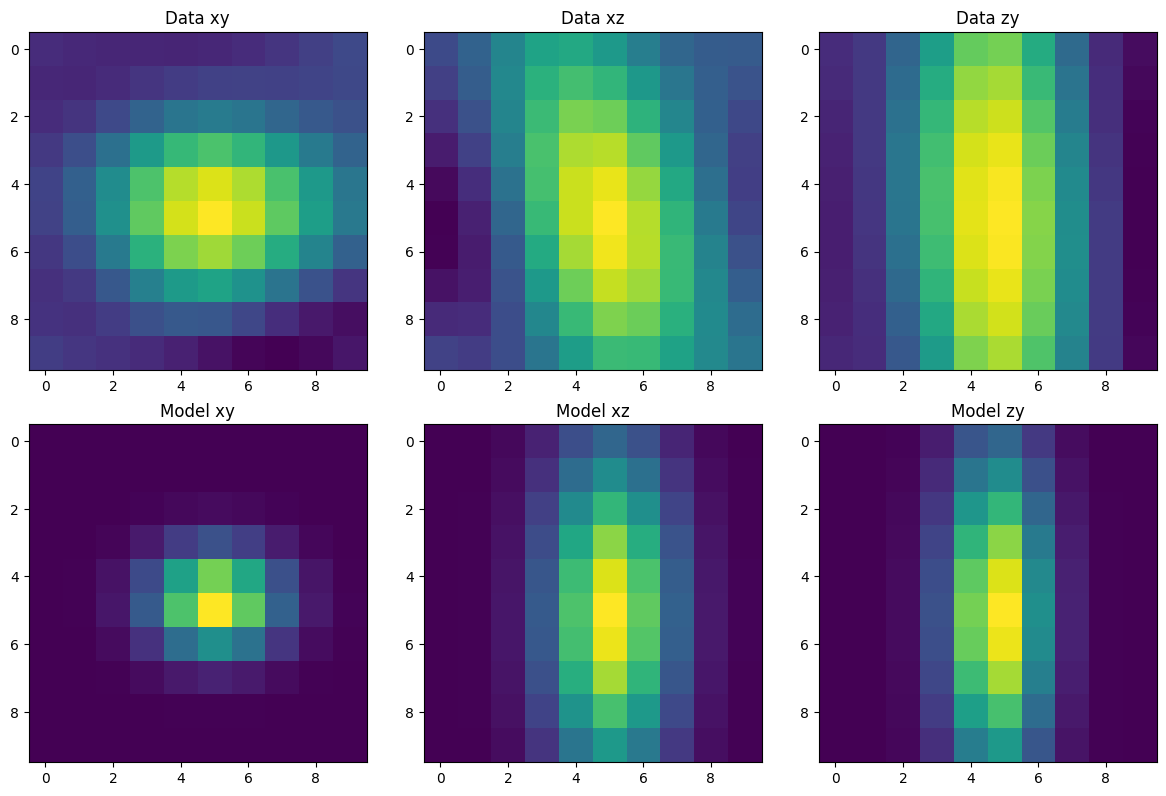

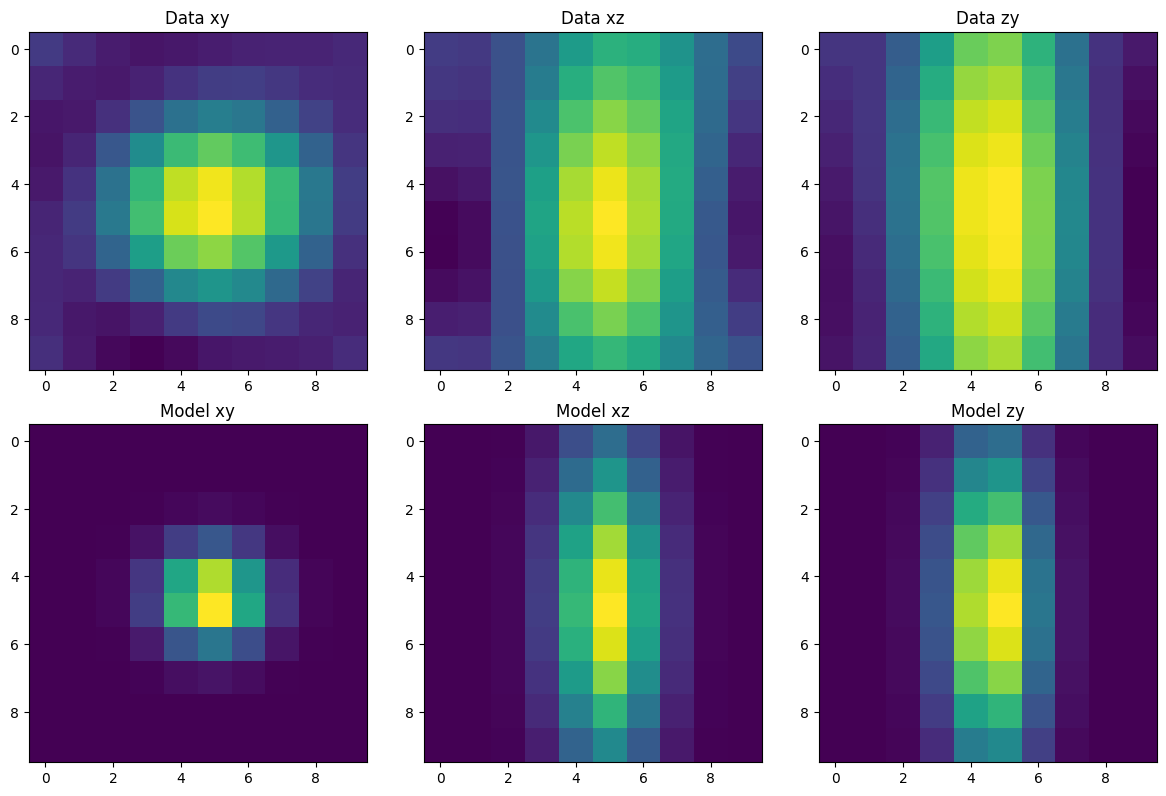

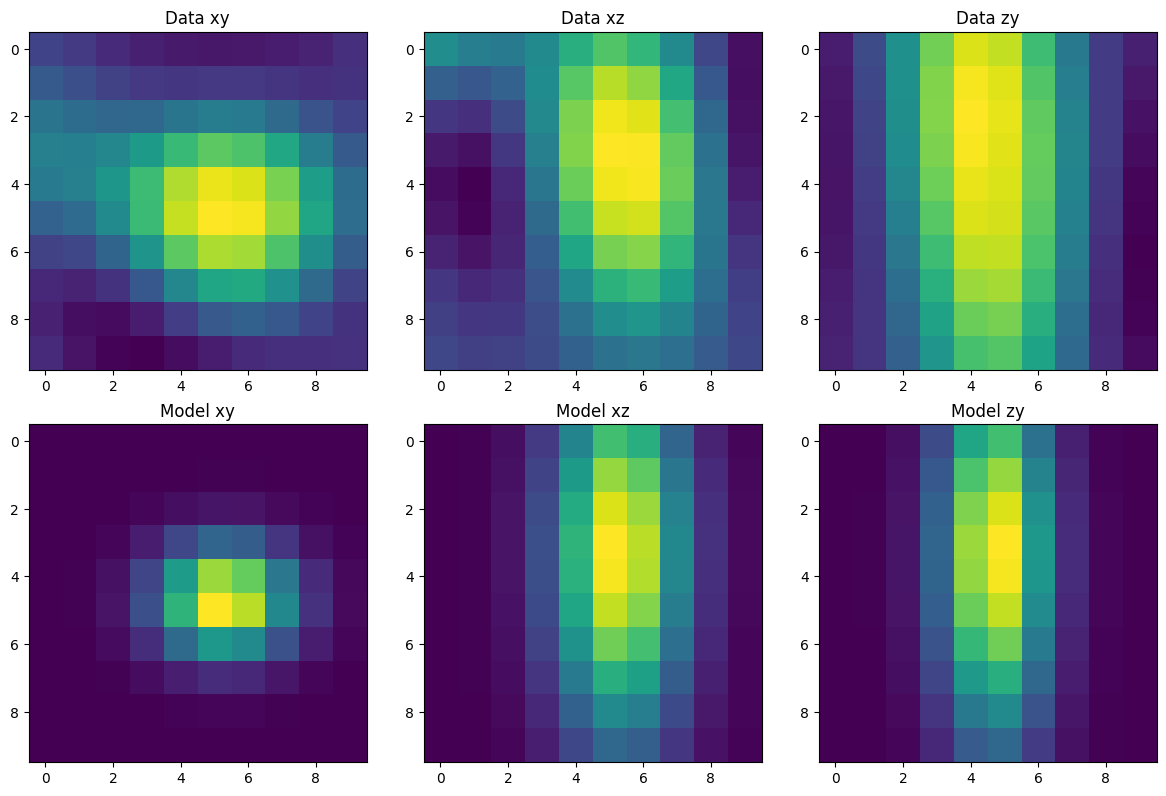

In [9]:
data = refined_peak_data["boxes"].cpu()
model = refined_peak_data["output"].detach().cpu()
refined_peak_data = refined_peak_data["refined_peaks"]
for i in [0,50,100,150]:
    fig, [[dxy,dxz,dzy],[mxy,mxz,mzy]] = plt.subplots(2, 3, figsize=(12, 8))

    dxy.imshow(data[i].sum(dim=0))
    dxy.set_title("Data xy")
    dxz.imshow(data[i].sum(dim=1))
    dxz.set_title("Data xz")
    dzy.imshow(data[i].sum(dim=2))
    dzy.set_title("Data zy")
    mxy.imshow(model[i].sum(dim=0))
    mxy.set_title("Model xy")
    mxz.imshow(model[i].sum(dim=1))
    mxz.set_title("Model xz")
    mzy.imshow(model[i].sum(dim=2))
    mzy.set_title("Model zy")
    plt.tight_layout()
    plt.show()

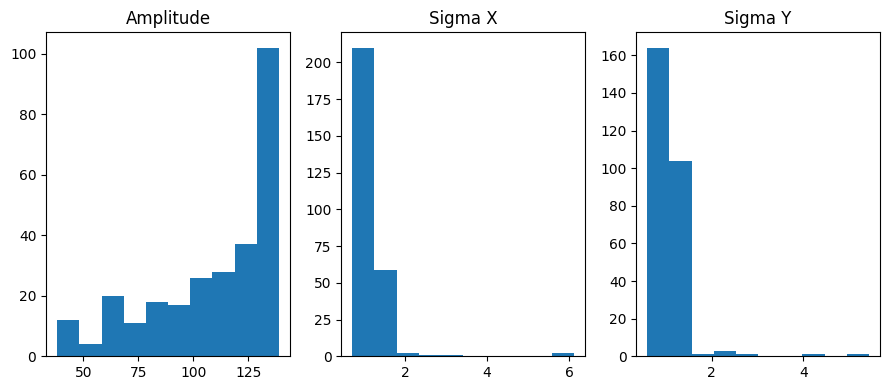

In [15]:
fig, [pl1, pl2,pl3] = plt.subplots(1, 3, figsize=(9, 4))
pl1.hist(refined_peak_data['amplitude'])
pl1.set_title("Amplitude")
pl2.hist(refined_peak_data['sigma_x'])
pl2.set_title("Sigma X")
pl3.hist(refined_peak_data['sigma_y'])
pl3.set_title("Sigma Y")
plt.tight_layout()
pass

In [16]:
filtered_peak_data = refined_peak_data[
    (refined_peak_data['amplitude'] > 75) &
    (refined_peak_data['sigma_x'] < 2) &
    (refined_peak_data['sigma_y'] < 2)
]

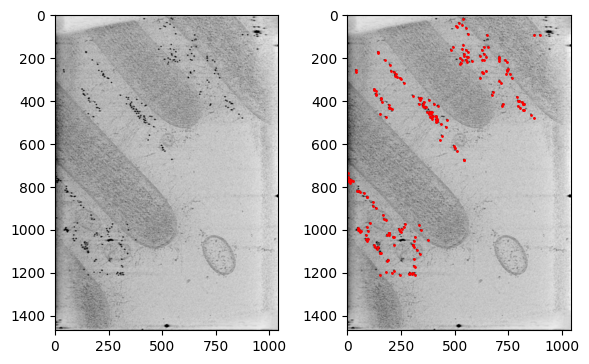

In [17]:
fig, [pl1, pl2] = plt.subplots(1, 2, figsize=(6, 4))
tomo_data_cpu = tomo_data.cpu()
pl1.imshow(torch.min(tomo_data_cpu, dim=0).values, cmap='gray',interpolation='mitchell', vmin=0, vmax=70)
pl2.imshow(torch.min(tomo_data_cpu, dim=0).values, cmap='gray',interpolation='mitchell', vmin=0, vmax=70)
pl2.plot(filtered_peak_data['x'],filtered_peak_data['y'], 'r.', markersize=2)
plt.tight_layout()
plt.show()